<a href="https://colab.research.google.com/github/sumedhekaru/Analysing-Student-Reviews/blob/master/Analysing_student_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Every semester, the students have the opportunity to review me using the feedback tools provided by my university, so I am a professor. I usually read every one of those to improve my teaching skills. 

Now imagine a review system that produces 100s of reviews if not 1000s of reviews on a product or service. Reading every review might be almost impossible. That's where we need machine learning techniques. Analyzing reviews are very useful to get the customer's voice and improve the product or service in the e-commerce world.

The goal here is to use ***Text Mining*** techniques to examine a collection of reviews or unstructured data and quickly understand the important points. For my case, it is only a few reviews (about 30). But these techniques can be scalable to solve larger problems. 



Let's load the packages needed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

#from PIL import Image
from wordcloud import WordCloud, STOPWORDS
#from IPython.display import Image as im

from bs4 import BeautifulSoup as bs
import requests as rs # to downolad web data

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/grive')
root_path= 'gdrive/My drive/Colab Notebooks/'
print('Done!')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/grive
Done!


I found that retemyprofessor.com only providing 20 reviews. If you want to see more student reviews, you have to go to the bottom of the webpage and click "show more". I found that as you click the button "show more" continuously, eventually you can see all reviews in one webpage. When I get to there, I saved the webpage and loaded the html file to google drive. Then I am using google's drive package to access those data.

Data were in /content/sample_data

In [2]:
!dir /content/sample_data/

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


# Data
For my case, students are providing reviews on a system that is provided by the university. However, I am pretty sure I am not allowed to post any of those publicly. On the other hand, https://www.ratemyprofessors.com collect some reviews from students. I am not here to judge this service good or bad. But I am going to analyze the reviews posted on this site about me. 

The site collects several information students.  These include overall rating, level of difficulty of the course, attendance policy, etc. But the primary data for this project comes from the comment paragraph.

While I can go and copy past individual text reviews, I would like to use web scoop technique to scoop the data. That way, I can do this over and over when new reviews are posted. Also, I can compare different professors. 

You can see I have several URLs listed below. But I am going to use only one link at a time. Mine is on the top. I am using ***request*** package to download the data and use ***BeautifulSoup*** package to extract the components I need.

I also pre-downloaded and saved some data in the hard drive. *open* command is used to open the html file and read it.

In [0]:
# Some stop words 
STOPWORDS2 = {'class','student','students','teacher','professor'}

#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2363605' # Sumedhe Karunarathne
#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=963105'  # Michelle
#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1422659'  # Bob
#url = 'https://www.ratemyprofessors.com/campusRatings.jsp?sid=5048'  # Campus
#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=971281'   # Joe
#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=839506' # Rita
#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=839496'
#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2363605' # Janet
#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1353819' # Michelle M
#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1738320&showMyProfs=true' # olemiss Noel Mann

# source = rs.get(url)
#soup = bs(source.content,'lxml')

#fileName = 'William Dwyer at University of Memphis - RateMyProfessors.com'

soup = bs(open('/content/grive/My Drive/Colab Notebooks/Sumedhe Karunarathne at Baptist College of Health Sciences - RateMyProfessors.com.html'),'lxml')
#soup = bs(open('/content/grive/My Drive/Colab Notebooks/William Dwyer at University of Memphis - RateMyProfessors.com.html'),'lxml')
#print(soup.prettify())

Now the web data are in the variable Soup. It is time to analyze the body of the web page and get the data. Using the Google Chromes *View Source* tool, I found that data contain three containers, 1. Rating - information about the numerical rating, 2. class - information about which teaching class, and 3. comments - text comments from students. I am going to scoop the data from these three sections next. 

Let's start processing ***'rating'*** section. This section contains 4 pieces of information that we could use.
1. The date of the rating is posted 
1. Numerical overall rating going from 1 to 5
1. The categorical ratings ('Awesome', 'Good', and 'Awful')
1. Level of the difficulty of the particular class

In [0]:
def getRatings(soup):
  content = soup.body.findAll(class_ = 'rating')

  print(len(content))

  #print(content)

  # Place holders for various data
  ratings = []
  dates = []
  scores = []
  difficulties = []

  # Decote the "rating Block"
  for line in content[1:]:
    # Dates
    date = line.find('div')
    dates.append('NaN' if date is None else date.text)
    # print(date)
    #dates.append(line.find('div').text)  
  
    # Overall ratings
    rating = line.find('span')
    ratings.append('NaN' if rating is None else rating.text)
    #print(rating)
    #ratings.append(rating)
  
    # Finding scores
    score  = line.find('span', class_ = 'score') 
    scores.append('NaN' if score is None else score.text)
 
    # Finding Difficulty Level
    difficulty  = line.find('span', {"class" : re.compile('score inverse')})
    difficulties.append('NaN' if difficulty is None else difficulty.text)
    
  df = pd.DataFrame(dates, columns = ['date'])
  df['rating'] = ratings
  df['score'] = scores
  df['difficulty'] = difficulties

  #print(ratings)
  #print(dates)
  #print(scores)
  #print(difficulties)

  df = df[df.date != 'NaN']
  df = df[df.difficulty != 'NaN']

  return df



Let's obtain the review data from the webpage and create a pandas data frame

In [5]:
reviewData = getRatings(soup)
reviewData.head()

32


,date,rating,score,difficulty
0,07/25/2019,awesome,5.0,2.0
1,12/01/2018,awesome,5.0,4.0
2,12/01/2018,awesome,5.0,4.0
3,11/27/2018,awesome,5.0,4.0
4,11/27/2018,awesome,5.0,3.0


The class section contains more data regarding the class student took before placing this review. The information we have are
1. Name of the class they took.
1. Whether it is taken for credits or not
1. Is the attendance is mandatory or not
1. If the student would take this instructor again or not
1. Grades received after completing the course 
One thing to note that a student doesn't have to fill all of the above data. Therefore, some data are missing. We just need to catch that when we collecting the data. 

In [0]:
def getClass(soup,df):

  content = soup.body.findAll(class_ = 'class')

  print(len(content))

  names = []
  forCredits = []
  attendances = []
  textbooks = []
  takeAgains = []
  grades = []

  for line in content[1:]:
    name = line.find(class_ = 'name')
    names.append('NaN' if name is None else name.text)
  
    forCredit = line.find(class_ = 'credit')
    forCredits.append('NaN' if forCredit is None else forCredit.text.replace('For Credit: ',''))
  
    attendance = line.find(class_ = 'attendance')
    attendances.append('NaN' if attendance.span is None else attendance.span.text)
  
    textbook = line.find(class_ = 'textbook-used')
    textbooks.append('NaN' if textbook is None else textbook.text.replace('Textbook Used: ',''))
  
    takeAgain = line.find(class_ = 'would-take-again')
    takeAgains.append('NaN' if takeAgain is None else takeAgain.text.replace('Would Take Again: ',''))
  
  
    grade = line.find(class_ = 'grade')
    grades.append('NaN' if grade is None else grade.text.replace('Grade Received: ',''))


  df['name'] = names
  df['forCredit'] = forCredits
  df['attendance'] = attendances
  df['textbook'] = textbooks
  df['takeAgain'] = takeAgains
  df['grade'] = grades

  # print(df)
  return df
  


Let's add review data to the date frame.

In [7]:
reviewData2 = getClass(soup,reviewData)
reviewData2.head()

29


,date,rating,score,difficulty,name,forCredit,attendance,textbook,takeAgain,grade
0,07/25/2019,awesome,5.0,2.0,PHY305,Yes,Mandatory,No,Yes,A
1,12/01/2018,awesome,5.0,4.0,PHY30501,Yes,N/A,Yes,Yes,N/A
2,12/01/2018,awesome,5.0,4.0,PHY305,Yes,Mandatory,Yes,Yes,Not sure yet
3,11/27/2018,awesome,5.0,4.0,PHY315,Yes,Mandatory,Yes,Yes,N/A
4,11/27/2018,awesome,5.0,3.0,PHY315,Yes,N/A,Yes,Yes,N/A


Next component to read is the comment section of the webpage. The comment section contains two components.
1. **key comments** - student can choose up to 3 key comments from a pre-defined list contains items such as 'lots of homework', 'Skip the classes? won't pass'. 
1. **comments** - actual descriptive comments from students. 

We will use our ***text mining*** strategies for both of these components. Let's start by creating a function to read comments data.

In [0]:
def getReviews(soup,df):
  content = soup.body.findAll(class_ = 'comments')

  comments = []
  keycomments = []

  for line in content:
    comment = line.find(class_ = 'commentsParagraph')
    # print(comment)
    comments.append('NaN' if comment is None else comment.text.strip())
    #comments.append(comment)
  
 
    keycomment = line.find(class_ = 'tagbox')
    keycomments.append('NaN' if keycomment is None else keycomment.text.strip().split('\n'))
    #keycomments.append(keycomment.text.strip().split('\n'))

  
  df['comments'] = comments
  df['keyComments'] = keycomments

  return df
  #print(comments)
  #print(keycomments)
  # len(comments)

Obtain the review data from the website.

In [9]:
reviewData3 = getReviews(soup,reviewData2)
reviewData3.head()

,date,rating,score,difficulty,name,forCredit,attendance,textbook,takeAgain,grade,comments,keyComments
0,07/25/2019,awesome,5.0,2.0,PHY305,Yes,Mandatory,No,Yes,A,I had Dr. Karu for physics I and he is an amaz...,"[CARING, CLEAR GRADING CRITERIA, AMAZING LECTU..."
1,12/01/2018,awesome,5.0,4.0,PHY30501,Yes,N/A,Yes,Yes,N/A,Dr. Karu was always willing to help anyone who...,"[RESPECTED, ACCESSIBLE OUTSIDE CLASS, GIVES GO..."
2,12/01/2018,awesome,5.0,4.0,PHY305,Yes,Mandatory,Yes,Yes,Not sure yet,I previous took physic in high-school and it w...,"[PARTICIPATION MATTERS, RESPECTED, SKIP CLASS?..."
3,11/27/2018,awesome,5.0,4.0,PHY315,Yes,Mandatory,Yes,Yes,N/A,Dr. Karu was an amazing instructor! He was pat...,"[GIVES GOOD FEEDBACK, SKIP CLASS? YOU WON'T PA..."
4,11/27/2018,awesome,5.0,3.0,PHY315,Yes,N/A,Yes,Yes,N/A,He is the best physics professor that Ive had....,"[GIVES GOOD FEEDBACK, ACCESSIBLE OUTSIDE CLASS..."


# Data Cleanup
The first thing I like to do is get rid of characters like full stops, commas, and single quotation marks, question marks, and parenthesis. Let's write a function for that.

In [0]:
def cleanUpdots(ws):

  for i in range(len(ws)):
    w = ws[i]
    w = w.replace(',','')
    w = w.replace('.','')
    w = w.replace('','')
    w = w.replace('"','')
    w = w.replace('(','')
    w = w.replace(')','')
    ws[i] = w

  return ws 

Let's start cleaning up.

In [11]:
words1 = ' '.join(reviewData3.keyComments.sum())

words2 = reviewData3.comments.sum()
words = words1.split(' ') + words2.split(' ')

# Any words less than two characters like a, an, .. may be not useful.
words = [w for w in words if len(w) > 2]  

# Remove , . etc
words = cleanUpdots(words)

# Convert everything to lovwer case
words = [w.lower() for w in words]

# Get rid of the common words, that are not useful to review
words = [w for w in words if w not in STOPWORDS]

# Is there anything extra you need to get rid of
words = [w for w in words if w not in STOPWORDS2]

print('Number of words = ' + str(len(words))) 

Number of words = 485


# Analysis
This is the most important path. Now data is prepared, time to analyze the data. We can see that we have a lot of unique numbers in these reviews. The question is which words appear the most? To find that we can use ***WordCloud*** package. It will find the freqeuency of unique words and with that we can create a word cloud picture.

In [12]:
wc = WordCloud(background_color="white", max_words=2000,width=1920, height=1080)
clean_string = ','.join(words)
print(clean_string)
wc.generate(clean_string)

caring,clear,grading,criteria,amazing,lectures,respected,accessible,outside,gives,good,feedback,participation,matters,respected,skip,class?,pass,gives,good,feedback,skip,class?,pass,amazing,lectures,gives,good,feedback,accessible,outside,clear,grading,criteria,amazing,lectures,clear,grading,criteria,accessible,outside,amazing,lectures,gives,good,feedback,clear,grading,criteria,clear,grading,criteria,amazing,lectures,gives,good,feedback,caring,skip,class?,pass,accessible,outside,skip,class?,pass,accessible,outside,caring,accessible,outside,lots,homework,skip,class?,pass,skip,class?,pass,caring,accessible,outside,gives,good,feedback,respected,lots,homework,respected,accessible,outside,gives,good,feedback,accessible,outside,gives,good,feedback,skip,class?,pass,accessible,outside,respected,amazing,lectures,lots,homework,gives,good,feedback,skip,class?,pass,clear,grading,criteria,participation,matters,gives,good,feedback,respected,accessible,outside,skip,class?,pass,accessible,outside,lots,

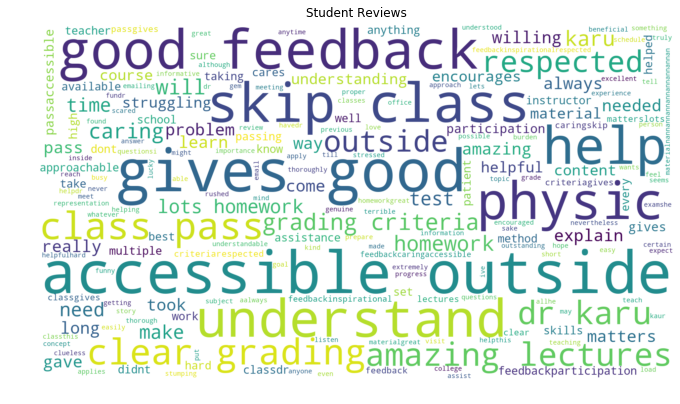

In [13]:
f = plt.figure(figsize = (25,25))
f.add_subplot(1,2, 2)
plt.imshow(wc, interpolation='bilinear')
plt.title('Student Reviews')
plt.axis("off")
plt.show()

In [14]:
# Convert numerical data to correct types
reviewData3.date = pd.to_datetime(reviewData3.date)
reviewData3.score = reviewData.score.astype(float)
reviewData3.difficulty = reviewData3.difficulty.astype(float)
print(reviewData3.dtypes)
reviewData3.head()


date           datetime64[ns]
rating                 object
score                 float64
difficulty            float64
name                   object
forCredit              object
attendance             object
textbook               object
takeAgain              object
grade                  object
comments               object
keyComments            object
dtype: object


,date,rating,score,difficulty,name,forCredit,attendance,textbook,takeAgain,grade,comments,keyComments
0,2019-07-25,awesome,5.0,2.0,PHY305,Yes,Mandatory,No,Yes,A,I had Dr. Karu for physics I and he is an amaz...,"[CARING, CLEAR GRADING CRITERIA, AMAZING LECTU..."
1,2018-12-01,awesome,5.0,4.0,PHY30501,Yes,N/A,Yes,Yes,N/A,Dr. Karu was always willing to help anyone who...,"[RESPECTED, ACCESSIBLE OUTSIDE CLASS, GIVES GO..."
2,2018-12-01,awesome,5.0,4.0,PHY305,Yes,Mandatory,Yes,Yes,Not sure yet,I previous took physic in high-school and it w...,"[PARTICIPATION MATTERS, RESPECTED, SKIP CLASS?..."
3,2018-11-27,awesome,5.0,4.0,PHY315,Yes,Mandatory,Yes,Yes,N/A,Dr. Karu was an amazing instructor! He was pat...,"[GIVES GOOD FEEDBACK, SKIP CLASS? YOU WON'T PA..."
4,2018-11-27,awesome,5.0,3.0,PHY315,Yes,N/A,Yes,Yes,N/A,He is the best physics professor that Ive had....,"[GIVES GOOD FEEDBACK, ACCESSIBLE OUTSIDE CLASS..."


In [15]:
reviewData3.describe()

,score,difficulty
count,28.000000,28.000000
mean,4.857143,3.821429
std,0.448395,0.611832
min,3.000000,2.000000
25%,5.000000,4.000000
50%,5.000000,4.000000
75%,5.000000,4.000000
max,5.000000,5.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a0270d6d8>,
      dtype=object)

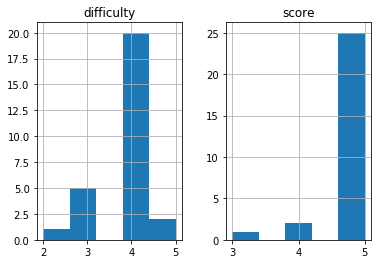

In [16]:
reviewData3.hist(bins = 5)

In [17]:
df = pd.DataFrame(clean_string.split(','),columns =['words'])
df.head()


,words
0,caring
1,clear
2,grading
3,criteria
4,amazing


In [18]:
df2 = df.groupby(by = 'words').size().reset_index(name = 'count')
#df2 = df2.reindex()
df2 = df2.sort_values(by='count',ascending=False)
df2.head()



,words,count
134,outside,19
73,good,17
71,gives,15
2,accessible,13
101,karu,12


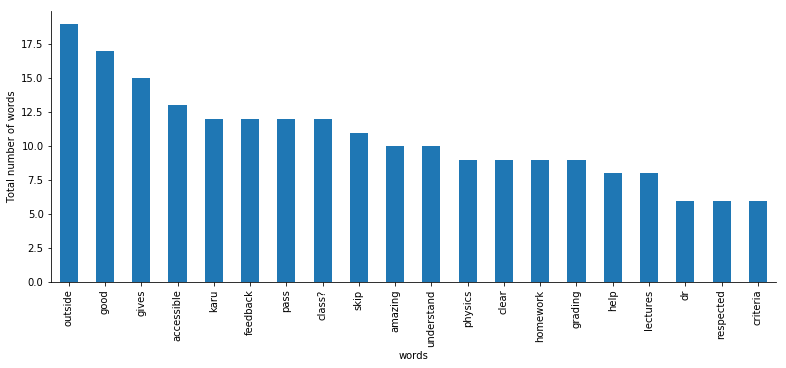

In [19]:
ax = df2.iloc[0:20].plot.bar(x = 'words', y = 'count', figsize=(13,5))

# Cleanup a bit
ax.set_ylabel('Total number of words')
ax.legend(bbox_to_anchor=(1, 1.))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()


# This Project is not com completed yet. I am still working on this as I have time.